In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import cvxpy as cvx
import matplotlib.pyplot as plt
import seaborn as sns

def rebalance(h, r_hat, costs, SIGMA, RISK_AVERSION):
    u = cvx.Variable(len(pred_returns.columns))
    RISK = cvx.quad_form(h+u, SIGMA)
    obj = cvx.Maximize(r_hat@h + r_hat@u - costs@u - RISK_AVERSION*RISK)
    constr = [h+u >= 0, sum(u)+costs@u == 0]
    prob = cvx.Problem(obj, constr)
    prob.solve()
    
    return u.value, prob.value

def compressor(u, op_pr, h, r_true, nan_sign):
    '''
    Функиция округляет вектор операций u, ориентируясь на цены в момент времени.
    
    В будущем подумать над ситуацией когда у нас есть актив с прошлой итерации
    мы хотим его продать но не знаем по какой рыночной цене это делать.
    '''
    for i in range(len(u)):
        if (i == len(u)-1) or (u[i] == 0): #Если алг. не предлагает действий или мы на банке - то пасс
            continue
        if r_true[i] == nan_sign: #Если не сможем посчитать доходность по активу в конце перода,то сливаем полностью
            u[-1] += u[i]
            u[i] = -h[i]
            u[-1] -= u[i]
        elif op_pr[i] == nan_sign: #Если не знаем закупочную цену
            if u[i] > 0: #Если хотели покупать, то не покупаем
                u[-1] += u[i]
                u[i] = 0
            else:      #Если хотели продавать(т.к он упадёт) то сливаем его как можно быстрее по любой цене
                u[-1] += u[i]
                u[i] = -h[i]
                u[-1] -= u[i] 
        else:                       
            operation = np.sign(u[i])
            
            res = abs(u[i]) - op_pr[i]*( abs(u[i]) //op_pr[i]) #Остаток от возможной операции
            
            u[i] = operation*( op_pr[i]*( abs(u[i]) //op_pr[i]) ) #Совершаем доступную операцию
            
            u[-1] += operation*(res) #Остаток скидываем в кэш + учитываем комиссию за u[i]
    return u

def toler1(u, tol):
    '''
    Функиция зануляет все координаты, тем самым убирая шум.
    '''
    for i in range(len(u)):
        if i == len(u)-1:
            continue
        elif abs(u[i]) < tol:
            u[-1] += u[i]
            u[i] = 0
    return u

def toler2(h_star, open_prices, r_true, nan_sign):
    '''
    Функиция зануляет все координаты, тем самым убирая шум.
    '''
    for i in range(len(h_star)):
        if i == len(h_star)-1:
            continue
        elif r_true[i] == nan_sign:
            h_star[-1] += h_star[i]
            h_star[i] = 0
        
    return h_star

def costing(h_star, cost):
    '''
    Функция 
    '''
    for i in range(len(h_star)):
        if i == len(h_star)-1 or h_star[i] == 0: #Если мы на банке или же не торгуем, то continue
            continue
        else:
            h_star[-1] -= cost*abs(h_star[i])
            
    return h_star

In [5]:
def backtest(pred_returns,
             fact_returns,
             opens,
             nan_sign,
             cash_account,
             tol,
             cost,
             risk_aversion,
             verbose = False):
#==============ПОДГОТОВКА К НАЧАЛУ ТЕСТА======================    
    #-----Составление ковариационной матрицы доходностей SIGMA-----
    returns_for_cov = fact_returns.copy()
    for i in list(returns_for_cov.columns):
        returns_for_cov[i] = returns_for_cov[i].fillna(returns_for_cov[i].mean())
    SIGMA = np.cov( returns_for_cov.to_numpy().T )
    pred_returns = pred_returns.fillna(-100)
    trading_periods = list(pred_returns.index)
    nav = []
    h = np.zeros(len(pred_returns.columns))
    h[-1] = cash_account
    costs = np.repeat(cost, len(pred_returns.columns) )
    costs[-1] = 0
     
#==============ЗАПУСК ТЕСТА====================== 
    for period in trading_periods:
            
        #------Подготовка всех данных для периода-----
        r_hat = np.array(pred_returns.loc[period])
        open_prices = np.array(opens.loc[period].fillna(nan_sign))
        r_true = np.array(fact_returns.loc[period].fillna(nan_sign))
        
        #------Перебалансировка и подгон под актуальные цены-------
        u_star, portfolio_ret = rebalance(h, r_hat, costs, SIGMA, risk_aversion)
        
        u_star = toler1(u_star, tol)
        
        u_star = compressor(u_star, open_prices, h, r_true, nan_sign)
        
        #------Совершаем торговые операции-------
        h_star = h + u_star
        h_star = toler2(h_star, open_prices, r_true, nan_sign)
        h_star = costing(h_star, cost)
        
        #------Сохраняем стоимость портфеля до периода----
        old_NAV = sum(h)
        
        #------Получаем реализацию в конце периода-------
        h = (1 + r_true)*h_star
        nav.append(sum(h))
        
        if verbose:
        #================ИНФОРМАЦИЯ=================
            print(f'Период: {period}')
            print(f'Сумма до : {old_NAV}')
            print(f'Сумма после : {sum(h)}')
            print('-------------------------')
    if verbose:    
        earned = round(sum(h) - cash_account, 2)
        global_return = round( (sum(h) - cash_account)/cash_account * 100 , 2)
        print(f'Сумма в начале периода торговли : {cash_account}')
        print(f'Сумма в конце периода торговли : {sum(h)}')
        print(f'Заработок с {trading_periods[0][:10]} по {trading_periods[-1][:10]} составил {earned}') 
        print(f'Доходность с {trading_periods[0][:10]} по {trading_periods[-1][:10]} составила {global_return} % годовых')
    
    return cost, risk_aversion, nav

In [6]:
pred_returns = pd.read_csv('cvxportfolio_pred_returns', index_col='Date')
pred_returns['cash'] = 0

fact_returns = pd.read_csv('cvxportfolio_fact_returns', index_col='Date')
fact_returns['cash'] = 0

closes = pd.read_csv('cvxportfolio_fact_closes', index_col='Date')

opens = pd.read_csv('cvxportfolio_fact_opens', index_col='Date')
opens['cash'] = 0

In [7]:
# cost, risk_aversion, nav = backtest(pred_returns = pred_returns,
#              fact_returns = fact_returns,
#              opens = opens,
#              nan_sign = 776655,
#              cash_account = 100000,
#              tol = 1,
#              cost = 0.004,
#              risk_aversion = 1/8)

In [26]:
cost_dict = {}
for cost in [0.003, 0.002, 0.001]:
    risk_dict = {}
    for risk_aversion in [1/28, 1/32, 1/48, 1/60]:
        cost, risk_aversion, nav = backtest(pred_returns = pred_returns,
             fact_returns = fact_returns,
             opens = opens,
             nan_sign = 776655,
             cash_account = 100000,
             tol = 1,
             cost = cost,
             risk_aversion = risk_aversion,
             verbose = False)
        risk_dict[risk_aversion] = nav
    cost_dict[cost] = risk_dict
    print(f'Посчитано для cost={cost}')

Посчитано для cost=0.003
Посчитано для cost=0.002
Посчитано для cost=0.001


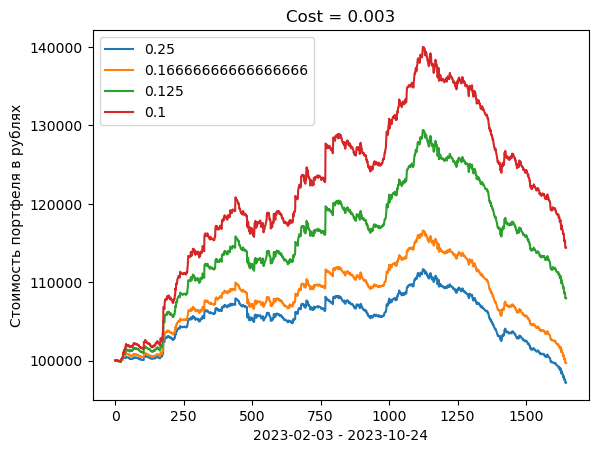

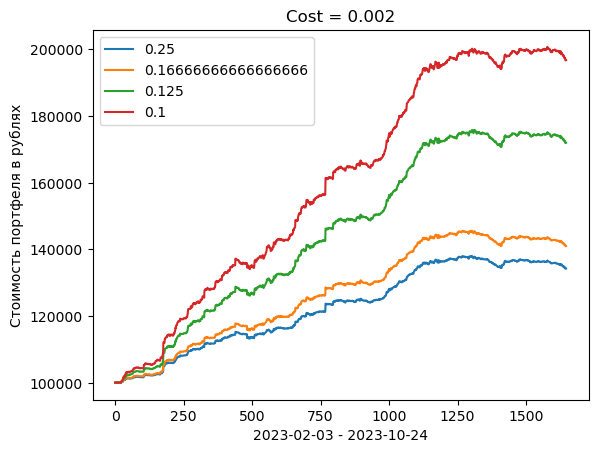

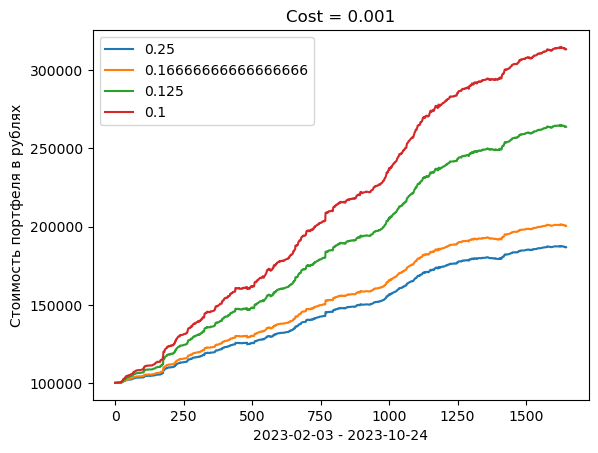

In [27]:
for cost in [0.003, 0.002, 0.001]:
    for risk_aversion in [1/28, 1/32, 1/48, 1/60]:
        plt.plot( cost_dict[cost][risk_aversion] )
    plt.title(f'Cost = {cost}')
    plt.xlabel('2023-02-03 - 2023-10-24')
    plt.ylabel('Стоимость портфеля в рублях')
    plt.legend([1/4, 1/6, 1/8, 1/10, 1/12, 1/14, 1/16, 1/18, 1/20, 1/16])
    plt.show()

In [321]:
nav = []

h = np.zeros(len(pred_returns.columns))
h[-1] = cash_account
for period in trading_periods:
        
    #------Подготовка всех данных для периода-----
    r_hat = np.array(pred_returns.loc[period])
    open_prices = np.array(opens.loc[period].fillna(nan_sign))
    r_true = np.array(fact_returns.loc[period].fillna(nan_sign))
    costs = np.repeat(cost, len(pred_returns.columns) )
    costs[-1] = 0
    RISK_AVERSION = 1/8
    
    #------Перебалансировка и подгон под актуальные цены-------
    u_star, portfolio_ret = rebalance(h, r_hat, costs, SIGMA, RISK_AVERSION)
    
    u_star = toler1(u_star, tol)
    
    u_star = compressor(u_star, open_prices, h, r_true, nan_sign)
    
    #------Совершаем торговые операции-------
    h_star = h + u_star
    h_star = toler2(h_star, open_prices, r_true)
    #h_star = costing(h_star, cost)
    #------Сохраняем стоимость портфеля до периода----
    old_NAV = sum(h)
    
    #------Получаем реализацию в конце периода-------
    h = (1 + r_true)*h_star
    nav.append(sum(h))
    
    
    
    #================ИНФОРМАЦИЯ=================
    print(f'Период: {period}')
    print(f'Сумма до : {old_NAV}')
    print(f'Сумма после : {sum(h)}')
    print('-------------------------')
    
earned = round(sum(h) - cash_account, 2)
global_return = round( (sum(h) - cash_account)/cash_account * 100 , 2)
print(f'Сумма в начале периода торговли : {cash_account}')
print(f'Сумма в конце периода торговли : {sum(h)}')
print(f'Заработок с {trading_periods[0][:10]} по {trading_periods[-1][:10]} составил {earned}') 
print(f'Доходность с {trading_periods[0][:10]} по {trading_periods[-1][:10]} составила {global_return} % годовых') 

Период: 2023-02-03 11:00:00
Сумма до : 100000.0
Сумма после : 100005.05991312455
-------------------------
Период: 2023-02-03 12:00:00
Сумма до : 100005.05991312455
Сумма после : 100008.07240767783
-------------------------
Период: 2023-02-03 13:00:00
Сумма до : 100008.07240767783
Сумма после : 100008.10933162358
-------------------------
Период: 2023-02-03 14:00:00
Сумма до : 100008.10933162358
Сумма после : 100007.96528068345
-------------------------
Период: 2023-02-03 15:00:00
Сумма до : 100007.96528068345
Сумма после : 100007.65727619064
-------------------------
Период: 2023-02-03 16:00:00
Сумма до : 100007.65727619064
Сумма после : 100007.54904027318
-------------------------
Период: 2023-02-03 17:00:00
Сумма до : 100007.54904027318
Сумма после : 100006.42820638692
-------------------------
Период: 2023-02-03 18:00:00
Сумма до : 100006.42820638692
Сумма после : 100006.59626791262
-------------------------
Период: 2023-02-03 18:45:00
Сумма до : 100006.59626791262
Сумма после : 10

Период: 2023-02-15 13:00:00
Сумма до : 100324.1133881528
Сумма после : 100327.660149334
-------------------------
Период: 2023-02-15 14:00:00
Сумма до : 100327.660149334
Сумма после : 100343.59795587629
-------------------------
Период: 2023-02-15 15:00:00
Сумма до : 100343.59795587629
Сумма после : 100347.86585290238
-------------------------
Период: 2023-02-15 16:00:00
Сумма до : 100347.86585290238
Сумма после : 100353.29382587013
-------------------------
Период: 2023-02-15 17:00:00
Сумма до : 100353.29382587013
Сумма после : 100355.9201960169
-------------------------
Период: 2023-02-15 18:00:00
Сумма до : 100355.9201960169
Сумма после : 100354.9611857706
-------------------------
Период: 2023-02-15 18:45:00
Сумма до : 100354.9611857706
Сумма после : 100356.38449206062
-------------------------
Период: 2023-02-16 11:00:00
Сумма до : 100356.38449206062
Сумма после : 100348.40406643094
-------------------------
Период: 2023-02-16 12:00:00
Сумма до : 100348.40406643094
Сумма после : 1

Период: 2023-02-28 15:00:00
Сумма до : 100357.58466468011
Сумма после : 100364.66169465819
-------------------------
Период: 2023-02-28 16:00:00
Сумма до : 100364.66169465819
Сумма после : 100369.43526371622
-------------------------
Период: 2023-02-28 17:00:00
Сумма до : 100369.43526371622
Сумма после : 100372.0686249911
-------------------------
Период: 2023-02-28 18:00:00
Сумма до : 100372.0686249911
Сумма после : 100377.72205874683
-------------------------
Период: 2023-02-28 18:45:00
Сумма до : 100377.72205874683
Сумма после : 100379.11808763807
-------------------------
Период: 2023-03-01 11:00:00
Сумма до : 100379.11808763807
Сумма после : 100381.51489905488
-------------------------
Период: 2023-03-01 12:00:00
Сумма до : 100381.51489905488
Сумма после : 100395.75659482295
-------------------------
Период: 2023-03-01 13:00:00
Сумма до : 100395.75659482295
Сумма после : 100389.1302611244
-------------------------
Период: 2023-03-01 14:00:00
Сумма до : 100389.1302611244
Сумма посл

Период: 2023-03-15 13:00:00
Сумма до : 102080.70541619229
Сумма после : 102089.39647680422
-------------------------
Период: 2023-03-15 14:00:00
Сумма до : 102089.39647680422
Сумма после : 102175.48850907305
-------------------------
Период: 2023-03-15 15:00:00
Сумма до : 102175.48850907305
Сумма после : 102191.36269781346
-------------------------
Период: 2023-03-15 16:00:00
Сумма до : 102191.36269781346
Сумма после : 102191.0471497339
-------------------------
Период: 2023-03-15 17:00:00
Сумма до : 102191.0471497339
Сумма после : 102182.11743234031
-------------------------
Период: 2023-03-15 18:00:00
Сумма до : 102182.11743234031
Сумма после : 102190.37455805807
-------------------------
Период: 2023-03-15 18:45:00
Сумма до : 102190.37455805807
Сумма после : 102192.94103271326
-------------------------
Период: 2023-03-16 11:00:00
Сумма до : 102192.94103271326
Сумма после : 102196.37616972883
-------------------------
Период: 2023-03-16 12:00:00
Сумма до : 102196.37616972883
Сумма по

Период: 2023-03-28 18:45:00
Сумма до : 103181.54105723173
Сумма после : 103186.31821809855
-------------------------
Период: 2023-03-29 11:00:00
Сумма до : 103186.31821809855
Сумма после : 103196.99257912752
-------------------------
Период: 2023-03-29 12:00:00
Сумма до : 103196.99257912752
Сумма после : 103166.7469819901
-------------------------
Период: 2023-03-29 13:00:00
Сумма до : 103166.7469819901
Сумма после : 103439.87275894066
-------------------------
Период: 2023-03-29 14:00:00
Сумма до : 103439.87275894066
Сумма после : 103464.3673918307
-------------------------
Период: 2023-03-29 15:00:00
Сумма до : 103464.3673918307
Сумма после : 103466.50834234178
-------------------------
Период: 2023-03-29 16:00:00
Сумма до : 103466.50834234178
Сумма после : 103482.18784951414
-------------------------
Период: 2023-03-29 17:00:00
Сумма до : 103482.18784951414
Сумма после : 103475.88010658819
-------------------------
Период: 2023-03-29 18:00:00
Сумма до : 103475.88010658819
Сумма посл

Период: 2023-04-07 18:00:00
Сумма до : 104145.79668912927
Сумма после : 104173.64403957911
-------------------------
Период: 2023-04-07 18:45:00
Сумма до : 104173.64403957911
Сумма после : 104174.56666045873
-------------------------
Период: 2023-04-10 11:00:00
Сумма до : 104174.56666045873
Сумма после : 104174.82055881254
-------------------------
Период: 2023-04-10 12:00:00
Сумма до : 104174.82055881254
Сумма после : 104167.74388644926
-------------------------
Период: 2023-04-10 13:00:00
Сумма до : 104167.74388644926
Сумма после : 104239.64184270587
-------------------------
Период: 2023-04-10 14:00:00
Сумма до : 104239.64184270587
Сумма после : 104258.1949867795
-------------------------
Период: 2023-04-10 15:00:00
Сумма до : 104258.1949867795
Сумма после : 104285.69242220718
-------------------------
Период: 2023-04-10 16:00:00
Сумма до : 104285.69242220718
Сумма после : 104285.57814816035
-------------------------
Период: 2023-04-10 17:00:00
Сумма до : 104285.57814816035
Сумма по

Период: 2023-04-19 17:00:00
Сумма до : 104978.07896481047
Сумма после : 104969.54166703054
-------------------------
Период: 2023-04-19 18:00:00
Сумма до : 104969.54166703054
Сумма после : 105041.39380256385
-------------------------
Период: 2023-04-19 18:45:00
Сумма до : 105041.39380256385
Сумма после : 105055.28645400284
-------------------------
Период: 2023-04-20 11:00:00
Сумма до : 105055.28645400284
Сумма после : 105052.33924521311
-------------------------
Период: 2023-04-20 12:00:00
Сумма до : 105052.33924521311
Сумма после : 105054.32791928566
-------------------------
Период: 2023-04-20 13:00:00
Сумма до : 105054.32791928566
Сумма после : 105053.3902998025
-------------------------
Период: 2023-04-20 14:00:00
Сумма до : 105053.3902998025
Сумма после : 105044.73534765297
-------------------------
Период: 2023-04-20 15:00:00
Сумма до : 105044.73534765297
Сумма после : 105055.130524753
-------------------------
Период: 2023-04-20 16:00:00
Сумма до : 105055.130524753
Сумма после 

Период: 2023-05-04 14:00:00
Сумма до : 105783.25807781583
Сумма после : 105798.74784448733
-------------------------
Период: 2023-05-04 15:00:00
Сумма до : 105798.74784448733
Сумма после : 105817.00047113498
-------------------------
Период: 2023-05-04 16:00:00
Сумма до : 105817.00047113498
Сумма после : 105926.71635482553
-------------------------
Период: 2023-05-04 17:00:00
Сумма до : 105926.71635482553
Сумма после : 105944.81108246515
-------------------------
Период: 2023-05-04 18:00:00
Сумма до : 105944.81108246515
Сумма после : 105959.33045066209
-------------------------
Период: 2023-05-04 18:45:00
Сумма до : 105959.33045066209
Сумма после : 105966.11390527472
-------------------------
Период: 2023-05-05 11:00:00
Сумма до : 105966.11390527472
Сумма после : 105990.20765102966
-------------------------
Период: 2023-05-05 12:00:00
Сумма до : 105990.20765102966
Сумма после : 106024.43676021101
-------------------------
Период: 2023-05-05 13:00:00
Сумма до : 106024.43676021101
Сумма 

Период: 2023-05-18 18:45:00
Сумма до : 106976.89238810311
Сумма после : 106973.75806387182
-------------------------
Период: 2023-05-19 11:00:00
Сумма до : 106973.75806387182
Сумма после : 106990.76097007301
-------------------------
Период: 2023-05-19 12:00:00
Сумма до : 106990.76097007301
Сумма после : 106993.57866600265
-------------------------
Период: 2023-05-19 13:00:00
Сумма до : 106993.57866600265
Сумма после : 107048.56379317197
-------------------------
Период: 2023-05-19 14:00:00
Сумма до : 107048.56379317197
Сумма после : 107065.20378434926
-------------------------
Период: 2023-05-19 15:00:00
Сумма до : 107065.20378434926
Сумма после : 107089.80652093094
-------------------------
Период: 2023-05-19 16:00:00
Сумма до : 107089.80652093094
Сумма после : 107124.87993795109
-------------------------
Период: 2023-05-19 17:00:00
Сумма до : 107124.87993795109
Сумма после : 107126.13658222488
-------------------------
Период: 2023-05-19 18:00:00
Сумма до : 107126.13658222488
Сумма 

Период: 2023-06-01 14:00:00
Сумма до : 108663.33768677273
Сумма после : 108685.35556851109
-------------------------
Период: 2023-06-01 15:00:00
Сумма до : 108685.35556851109
Сумма после : 108692.1783001662
-------------------------
Период: 2023-06-01 16:00:00
Сумма до : 108692.1783001662
Сумма после : 108791.55200391427
-------------------------
Период: 2023-06-01 17:00:00
Сумма до : 108791.55200391427
Сумма после : 108797.37940895773
-------------------------
Период: 2023-06-01 18:00:00
Сумма до : 108797.37940895773
Сумма после : 108811.0216731295
-------------------------
Период: 2023-06-01 18:45:00
Сумма до : 108811.0216731295
Сумма после : 108823.3058888183
-------------------------
Период: 2023-06-02 11:00:00
Сумма до : 108823.3058888183
Сумма после : 108820.74029230303
-------------------------
Период: 2023-06-02 12:00:00
Сумма до : 108820.74029230303
Сумма после : 108874.59347527933
-------------------------
Период: 2023-06-02 13:00:00
Сумма до : 108874.59347527933
Сумма после 

Период: 2023-06-15 17:00:00
Сумма до : 110721.18966490014
Сумма после : 110730.46415675497
-------------------------
Период: 2023-06-15 18:00:00
Сумма до : 110730.46415675497
Сумма после : 110765.1928119916
-------------------------
Период: 2023-06-15 18:45:00
Сумма до : 110765.1928119916
Сумма после : 110771.48400825827
-------------------------
Период: 2023-06-16 11:00:00
Сумма до : 110771.48400825827
Сумма после : 110774.86467392925
-------------------------
Период: 2023-06-16 12:00:00
Сумма до : 110774.86467392925
Сумма после : 110804.20683448213
-------------------------
Период: 2023-06-16 13:00:00
Сумма до : 110804.20683448213
Сумма после : 110795.88843399879
-------------------------
Период: 2023-06-16 14:00:00
Сумма до : 110795.88843399879
Сумма после : 110847.63747089988
-------------------------
Период: 2023-06-16 15:00:00
Сумма до : 110847.63747089988
Сумма после : 110853.55567733961
-------------------------
Период: 2023-06-16 16:00:00
Сумма до : 110853.55567733961
Сумма по

Период: 2023-06-29 12:00:00
Сумма до : 112041.05633660743
Сумма после : 111989.52193765904
-------------------------
Период: 2023-06-29 13:00:00
Сумма до : 111989.52193765904
Сумма после : 111998.27158956265
-------------------------
Период: 2023-06-29 14:00:00
Сумма до : 111998.27158956265
Сумма после : 112026.03438356318
-------------------------
Период: 2023-06-29 15:00:00
Сумма до : 112026.03438356318
Сумма после : 111984.9502489946
-------------------------
Период: 2023-06-29 16:00:00
Сумма до : 111984.9502489946
Сумма после : 112004.62994141474
-------------------------
Период: 2023-06-29 17:00:00
Сумма до : 112004.62994141474
Сумма после : 111988.18444836272
-------------------------
Период: 2023-06-29 18:00:00
Сумма до : 111988.18444836272
Сумма после : 112025.84112947117
-------------------------
Период: 2023-06-29 18:45:00
Сумма до : 112025.84112947117
Сумма после : 111988.2120024204
-------------------------
Период: 2023-06-30 11:00:00
Сумма до : 111988.2120024204
Сумма посл

Период: 2023-07-12 15:00:00
Сумма до : 113301.48481810723
Сумма после : 113321.39671982858
-------------------------
Период: 2023-07-12 16:00:00
Сумма до : 113321.39671982858
Сумма после : 113330.26637597667
-------------------------
Период: 2023-07-12 17:00:00
Сумма до : 113330.26637597667
Сумма после : 113368.94513417128
-------------------------
Период: 2023-07-12 18:00:00
Сумма до : 113368.94513417128
Сумма после : 113380.11677723406
-------------------------
Период: 2023-07-12 18:45:00
Сумма до : 113380.11677723406
Сумма после : 113414.78096496093
-------------------------
Период: 2023-07-13 11:00:00
Сумма до : 113414.78096496093
Сумма после : 113428.01388630051
-------------------------
Период: 2023-07-13 12:00:00
Сумма до : 113428.01388630051
Сумма после : 113478.8090581758
-------------------------
Период: 2023-07-13 13:00:00
Сумма до : 113478.8090581758
Сумма после : 113575.4799956114
-------------------------
Период: 2023-07-13 14:00:00
Сумма до : 113575.4799956114
Сумма посл

Период: 2023-07-24 14:00:00
Сумма до : 115670.00220076702
Сумма после : 115710.61845553132
-------------------------
Период: 2023-07-24 15:00:00
Сумма до : 115710.61845553132
Сумма после : 115708.19601999108
-------------------------
Период: 2023-07-24 16:00:00
Сумма до : 115708.19601999108
Сумма после : 115740.51866585138
-------------------------
Период: 2023-07-24 17:00:00
Сумма до : 115740.51866585138
Сумма после : 115771.302422199
-------------------------
Период: 2023-07-24 18:00:00
Сумма до : 115771.302422199
Сумма после : 115845.82379854016
-------------------------
Период: 2023-07-24 18:45:00
Сумма до : 115845.82379854016
Сумма после : 115854.10217370509
-------------------------
Период: 2023-07-25 11:00:00
Сумма до : 115854.10217370509
Сумма после : 115871.91226161132
-------------------------
Период: 2023-07-25 12:00:00
Сумма до : 115871.91226161132
Сумма после : 115959.39199415442
-------------------------
Период: 2023-07-25 13:00:00
Сумма до : 115959.39199415442
Сумма посл

Период: 2023-08-04 18:00:00
Сумма до : 118542.92377805144
Сумма после : 118577.3906583951
-------------------------
Период: 2023-08-04 18:45:00
Сумма до : 118577.3906583951
Сумма после : 118604.92803507898
-------------------------
Период: 2023-08-07 11:00:00
Сумма до : 118604.92803507898
Сумма после : 118614.98413416868
-------------------------
Период: 2023-08-07 12:00:00
Сумма до : 118614.98413416868
Сумма после : 118650.73138980276
-------------------------
Период: 2023-08-07 13:00:00
Сумма до : 118650.73138980276
Сумма после : 118664.78901726259
-------------------------
Период: 2023-08-07 14:00:00
Сумма до : 118664.78901726259
Сумма после : 118644.52461039335
-------------------------
Период: 2023-08-07 15:00:00
Сумма до : 118644.52461039335
Сумма после : 118687.94918051
-------------------------
Период: 2023-08-07 16:00:00
Сумма до : 118687.94918051
Сумма после : 118705.50622181177
-------------------------
Период: 2023-08-07 17:00:00
Сумма до : 118705.50622181177
Сумма после : 

Период: 2023-08-18 12:00:00
Сумма до : 120855.87144326136
Сумма после : 120866.13418879283
-------------------------
Период: 2023-08-18 13:00:00
Сумма до : 120866.13418879283
Сумма после : 120873.58659295939
-------------------------
Период: 2023-08-18 14:00:00
Сумма до : 120873.58659295939
Сумма после : 120887.8405498312
-------------------------
Период: 2023-08-18 15:00:00
Сумма до : 120887.8405498312
Сумма после : 120908.70019950224
-------------------------
Период: 2023-08-18 16:00:00
Сумма до : 120908.70019950224
Сумма после : 120913.92092099506
-------------------------
Период: 2023-08-18 17:00:00
Сумма до : 120913.92092099506
Сумма после : 120994.89976655778
-------------------------
Период: 2023-08-18 18:00:00
Сумма до : 120994.89976655778
Сумма после : 121018.76488412896
-------------------------
Период: 2023-08-18 18:45:00
Сумма до : 121018.76488412896
Сумма после : 121026.83974519254
-------------------------
Период: 2023-08-21 11:00:00
Сумма до : 121026.83974519254
Сумма по

Период: 2023-08-31 16:00:00
Сумма до : 122815.21121567694
Сумма после : 122856.23730924957
-------------------------
Период: 2023-08-31 17:00:00
Сумма до : 122856.23730924957
Сумма после : 122892.55574925206
-------------------------
Период: 2023-08-31 18:00:00
Сумма до : 122892.55574925206
Сумма после : 122919.12756088561
-------------------------
Период: 2023-08-31 18:45:00
Сумма до : 122919.12756088561
Сумма после : 122846.36199238486
-------------------------
Период: 2023-09-01 11:00:00
Сумма до : 122846.36199238486
Сумма после : 122857.11690151127
-------------------------
Период: 2023-09-01 12:00:00
Сумма до : 122857.11690151127
Сумма после : 122860.65965832143
-------------------------
Период: 2023-09-01 13:00:00
Сумма до : 122860.65965832143
Сумма после : 122861.96717544907
-------------------------
Период: 2023-09-01 14:00:00
Сумма до : 122861.96717544907
Сумма после : 122870.51239119002
-------------------------
Период: 2023-09-01 15:00:00
Сумма до : 122870.51239119002
Сумма 

Период: 2023-09-14 12:00:00
Сумма до : 124305.8223883021
Сумма после : 124306.67241130794
-------------------------
Период: 2023-09-14 13:00:00
Сумма до : 124306.67241130794
Сумма после : 124350.22879630126
-------------------------
Период: 2023-09-14 14:00:00
Сумма до : 124350.22879630126
Сумма после : 124397.42417202295
-------------------------
Период: 2023-09-14 15:00:00
Сумма до : 124397.42417202295
Сумма после : 124388.87376295573
-------------------------
Период: 2023-09-14 16:00:00
Сумма до : 124388.87376295573
Сумма после : 124412.12591294723
-------------------------
Период: 2023-09-14 17:00:00
Сумма до : 124412.12591294723
Сумма после : 124419.06085621796
-------------------------
Период: 2023-09-14 18:00:00
Сумма до : 124419.06085621796
Сумма после : 124437.14516852009
-------------------------
Период: 2023-09-14 18:45:00
Сумма до : 124437.14516852009
Сумма после : 124443.13930629859
-------------------------
Период: 2023-09-15 11:00:00
Сумма до : 124443.13930629859
Сумма п

Период: 2023-09-27 17:00:00
Сумма до : 126595.61901636688
Сумма после : 126603.41037709928
-------------------------
Период: 2023-09-27 18:00:00
Сумма до : 126603.41037709928
Сумма после : 126661.30994644194
-------------------------
Период: 2023-09-27 18:45:00
Сумма до : 126661.30994644194
Сумма после : 126767.13590623504
-------------------------
Период: 2023-09-28 11:00:00
Сумма до : 126767.13590623504
Сумма после : 126798.95583753813
-------------------------
Период: 2023-09-28 12:00:00
Сумма до : 126798.95583753813
Сумма после : 126778.80756127405
-------------------------
Период: 2023-09-28 13:00:00
Сумма до : 126778.80756127405
Сумма после : 126774.86399855785
-------------------------
Период: 2023-09-28 14:00:00
Сумма до : 126774.86399855785
Сумма после : 126804.34594954837
-------------------------
Период: 2023-09-28 15:00:00
Сумма до : 126804.34594954837
Сумма после : 126846.47146599027
-------------------------
Период: 2023-09-28 16:00:00
Сумма до : 126846.47146599027
Сумма 

Период: 2023-10-10 18:00:00
Сумма до : 128034.66780189605
Сумма после : 128086.22142479848
-------------------------
Период: 2023-10-10 18:45:00
Сумма до : 128086.22142479848
Сумма после : 128114.81732084068
-------------------------
Период: 2023-10-11 11:00:00
Сумма до : 128114.81732084068
Сумма после : 128148.09327913588
-------------------------
Период: 2023-10-11 12:00:00
Сумма до : 128148.09327913588
Сумма после : 128161.23041815488
-------------------------
Период: 2023-10-11 13:00:00
Сумма до : 128161.23041815488
Сумма после : 128183.42964636181
-------------------------
Период: 2023-10-11 14:00:00
Сумма до : 128183.42964636181
Сумма после : 128204.82578482632
-------------------------
Период: 2023-10-11 15:00:00
Сумма до : 128204.82578482632
Сумма после : 128217.0627280345
-------------------------
Период: 2023-10-11 16:00:00
Сумма до : 128217.0627280345
Сумма после : 128233.69077481187
-------------------------
Период: 2023-10-11 17:00:00
Сумма до : 128233.69077481187
Сумма по

Период: 2023-10-20 18:00:00
Сумма до : 129363.63052145543
Сумма после : 129326.69096694331
-------------------------
Период: 2023-10-20 18:45:00
Сумма до : 129326.69096694331
Сумма после : 129253.77909951536
-------------------------
Период: 2023-10-23 11:00:00
Сумма до : 129253.77909951536
Сумма после : 129345.20516304107
-------------------------
Период: 2023-10-23 12:00:00
Сумма до : 129345.20516304107
Сумма после : 129351.34189966203
-------------------------
Период: 2023-10-23 13:00:00
Сумма до : 129351.34189966203
Сумма после : 129361.97752302578
-------------------------
Период: 2023-10-23 14:00:00
Сумма до : 129361.97752302578
Сумма после : 129327.19820449309
-------------------------
Период: 2023-10-23 15:00:00
Сумма до : 129327.19820449309
Сумма после : 129348.57942538809
-------------------------
Период: 2023-10-23 16:00:00
Сумма до : 129348.57942538809
Сумма после : 129359.11991296303
-------------------------
Период: 2023-10-23 17:00:00
Сумма до : 129359.11991296303
Сумма 